### Theads 

Convolution

In [1]:
%matplotlib notebook

import ctypes
import os
import multiprocessing as mp
import multiprocessing.pool as mpPool

import numpy as np
from scipy import ndimage
from scipy.signal import convolve2d, gaussian

import astropy.io.fits as pf
import matplotlib.pyplot as plt

In [2]:
img = pf.getdata("LB.20140623.37347.fits")
img.shape

(4096, 1155)

In [3]:
def rescale(img, k=1, maxVal=255.0):
    mean, std = img.mean(), img.std()
    scale = maxVal / (2 * k* std)
    bias = - scale * (mean - std * k)
    nImg = img * scale + bias
    return nImg.clip(0, maxVal)

<IPython.core.display.Javascript object>


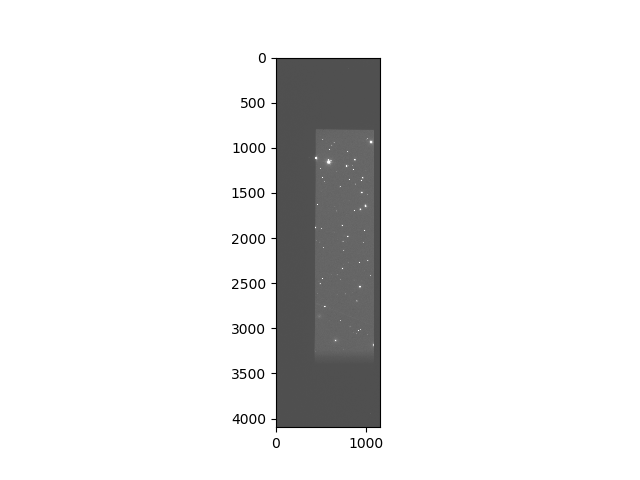

In [4]:
plt.figure()
plt.imshow(rescale(img), cmap='gray')

In [11]:
%%timeit
imgCv = ndimage.filters.gaussian_filter(img, 33)

2.19 s ± 236 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
plt.figure()
plt.imshow(rescale(imgCv), cmap='gray')

In [4]:
def workerFunction (i):
    global sharedOutData, chunkSize
    margin =130
    sy = slice(i*chunkSize, (i+1)*chunkSize)
    s1 = i* chunkSize - margin
    s2 = slice (margin, -margin)
    if s1 < 0:
        s1 = 0
        s2 = slice(0, chunkSize)
    sy1 = slice(s1, (i+1)*chunkSize+margin)
    #print (i)
    e1 = (i+1) * chunkSize + margin
    if e1 >= img.shape[0]:
        s2 = slice(min(s1, margin), chunkSize+margin, None)
    sharedDataOut[sy,:] = ndimage.filters.gaussian_filter(img[sy1,:], 33)[s2]

In [12]:
sharedDataOut = np.zeros(img.shape)
nParts = 12
chunkSize = img.shape[0]//nParts

In [14]:
%%timeit
# Test workerFunction, sequentially
for i in range(nParts):
    workerFunction (i)

3.69 s ± 338 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
with mpPool.ThreadPool (processes=nParts) as pool:
    pool.map(workerFunction, range(nParts))

1.02 s ± 37.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


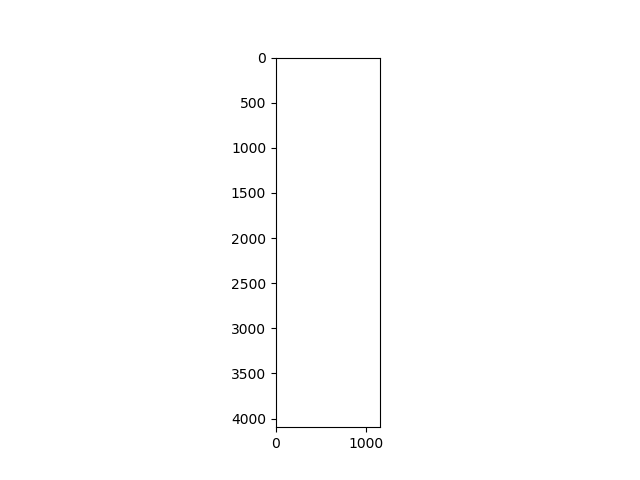

In [58]:
plt.figure()
dImg = sharedDataOut - imgCv
#plt.plot (dImg[:, dImg.shape[1]//2])
plt.imshow(sharedDataOut-imgCv, cmap='gray')